# Análise de Padrões Táticos no Futebol Europeu
## Pipeline Completo de Clusterização com K-Medoids

**Objetivo**: Identificar e analisar padrões táticos de times de futebol europeu utilizando clusterização (K-Medoids).

**Dataset**: Banco de dados SQLite com informações de times, partidas e atributos táticos do futebol europeu.

**Pipeline**:
1. Extração de dados do banco SQLite
2. Processamento e limpeza dos dados
3. Cálculo de métricas de desempenho
4. Normalização (Z-Score)
5. Determinação do número ideal de clusters (Método do Cotovelo e Silhueta)
6. Aplicação do algoritmo K-Medoids
7. Análise e visualização dos resultados

---

## 1. Importação de Bibliotecas

In [3]:
# Manipulação de dados
import pandas as pd
import numpy as np
import sqlite3

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids  # K-Medoids (mais robusto que K-Means)
from sklearn.metrics import silhouette_score

# Configurações
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Ignorar warnings
import warnings
warnings.filterwarnings('ignore')

print("✓ Bibliotecas importadas com sucesso!")

✓ Bibliotecas importadas com sucesso!


## 2. Extração de Dados do Banco SQLite

Nesta etapa, extraímos três tabelas principais do banco de dados:
- **Team_Attributes**: Atributos táticos dos times (notas da EA Sports)
- **Match**: Resultados das partidas
- **Team**: Nomes dos times

In [ ]:
# NOTA: Este código assume que você tem o arquivo 'database.sqlite' na pasta do projeto
# Se não tiver, você pode pular esta célula e carregar os CSVs diretamente

try:
    # Conectar ao banco de dados
    conn = sqlite3.connect('database.sqlite')
    
    # Extrair atributos táticos
    df_attributes = pd.read_sql_query("""
        SELECT team_api_id, date,
               buildUpPlaySpeed, buildUpPlayPassing,
               chanceCreationPassing, chanceCreationCrossing, chanceCreationShooting,
               defencePressure, defenceAggression, defenceTeamWidth
        FROM Team_Attributes
    """, conn)
    
    # Extrair partidas
    df_matches = pd.read_sql_query("""
        SELECT season, home_team_api_id, away_team_api_id, home_team_goal, away_team_goal
        FROM Match
    """, conn)
    
    # Extrair nomes dos times
    df_teams = pd.read_sql_query("SELECT team_api_id, team_long_name FROM Team", conn)
    
    # Fechar conexão
    conn.close()
    
    print("="*70)
    print("DADOS EXTRAÍDOS DO BANCO SQLITE")
    print("="*70)
    print(f"\n✓ Atributos Táticos: {df_attributes.shape[0]} registros")
    print(f"✓ Partidas: {df_matches.shape[0]} registros")
    print(f"✓ Times: {df_teams.shape[0]} times")
    
except FileNotFoundError:
    print("⚠️ Arquivo 'database.sqlite' não encontrado.")
    print("Carregando dados dos arquivos CSV pré-processados...\n")
    
    df_attributes = pd.read_csv('Análise de Padrões Táticos/Formatação da DATABASE/1_atributos_taticos_brutos.csv')
    df_matches = pd.read_csv('Análise de Padrões Táticos/Formatação da DATABASE/2_partidas_brutas.csv')
    df_teams = pd.read_csv('Tabelas/3_nomes_times.csv')
    
    print("✓ Dados carregados dos CSVs com sucesso!")

DADOS EXTRAÍDOS DO BANCO SQLITE

✓ Atributos Táticos: 1458 registros
✓ Partidas: 25979 registros
✓ Times: 299 times


In [5]:
# Visualizar primeiras linhas dos atributos táticos
print("\nAtributos Táticos (primeiras linhas):")
df_attributes.head()


Atributos Táticos (primeiras linhas):


,team_api_id,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
0,9930,2010-02-22 00:00:00,60,50,60,65,55,50,55,45
1,9930,2014-09-19 00:00:00,52,56,54,63,64,47,44,54
2,9930,2015-09-10 00:00:00,47,54,54,63,64,47,44,54
3,8485,2010-02-22 00:00:00,70,70,70,70,70,60,70,70
4,8485,2011-02-22 00:00:00,47,52,53,48,52,47,47,52


## 3. Processamento: Conversão de Data para Temporada

As temporadas de futebol europeu geralmente começam em agosto. Precisamos converter as datas em temporadas no formato `YYYY/YYYY+1`.

In [6]:
# Converter coluna 'date' para datetime
df_attributes['date'] = pd.to_datetime(df_attributes['date'])

# Função para determinar a temporada
def get_season(date_val):
    """Converte data em temporada (formato YYYY/YYYY+1)"""
    year = date_val.year
    month = date_val.month
    # Temporadas começam em agosto (mês 8)
    if month >= 8:
        return f"{year}/{year + 1}"
    else:
        return f"{year - 1}/{year}"

# Aplicar a função
df_attributes['season'] = df_attributes['date'].apply(get_season)

print("="*70)
print("CONVERSÃO DE DATA PARA TEMPORADA")
print("="*70)
print("\nExemplos de conversão:")
print(df_attributes[['date', 'season']].head(10))

CONVERSÃO DE DATA PARA TEMPORADA

Exemplos de conversão:
        date     season
0 2010-02-22  2009/2010
1 2014-09-19  2014/2015
2 2015-09-10  2015/2016
3 2010-02-22  2009/2010
4 2011-02-22  2010/2011
5 2012-02-22  2011/2012
6 2013-09-20  2013/2014
7 2014-09-19  2014/2015
8 2015-09-10  2015/2016
9 2010-02-22  2009/2010


## 4. Cálculo de Desempenho por Temporada

Calculamos o **saldo médio de gols** (gols feitos - gols sofridos) por partida para cada time em cada temporada.

In [7]:
# Processar partidas em casa
df_home = df_matches[['season', 'home_team_api_id', 'home_team_goal', 'away_team_goal']].copy()
df_home['gols_feitos'] = df_home['home_team_goal']
df_home['gols_sofridos'] = df_home['away_team_goal']
df_home = df_home.rename(columns={'home_team_api_id': 'team_api_id'})
df_home = df_home[['season', 'team_api_id', 'gols_feitos', 'gols_sofridos']]

# Processar partidas fora de casa
df_away = df_matches[['season', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].copy()
df_away['gols_feitos'] = df_away['away_team_goal']
df_away['gols_sofridos'] = df_away['home_team_goal']
df_away = df_away.rename(columns={'away_team_api_id': 'team_api_id'})
df_away = df_away[['season', 'team_api_id', 'gols_feitos', 'gols_sofridos']]

# Concatenar partidas em casa e fora
df_all_matches = pd.concat([df_home, df_away], ignore_index=True)

# Agrupar por time e temporada
df_desempenho = df_all_matches.groupby(['team_api_id', 'season']).agg({
    'gols_feitos': 'sum',
    'gols_sofridos': 'sum'
}).reset_index()

# Calcular número de partidas
df_partidas_count = df_all_matches.groupby(['team_api_id', 'season']).size().reset_index(name='num_partidas')
df_desempenho = df_desempenho.merge(df_partidas_count, on=['team_api_id', 'season'])

# Calcular saldo médio
df_desempenho['saldo_medio'] = (df_desempenho['gols_feitos'] - df_desempenho['gols_sofridos']) / df_desempenho['num_partidas']

print("="*70)
print("DESEMPENHO CALCULADO")
print("="*70)
print(f"\n✓ Total de registros (time x temporada): {df_desempenho.shape[0]}")
print("\nPrimeiros registros:")
df_desempenho.head(10)

DESEMPENHO CALCULADO

✓ Total de registros (time x temporada): 1481

Primeiros registros:


,team_api_id,season,gols_feitos,gols_sofridos,num_partidas,saldo_medio
0,1601,2008/2009,22,32,30,-0.333333
1,1601,2009/2010,40,30,30,0.333333
2,1601,2010/2011,29,32,30,-0.100000
3,1601,2011/2012,44,28,30,0.533333
4,1601,2012/2013,35,48,30,-0.433333
5,1601,2013/2014,40,38,30,0.066667
6,1601,2014/2015,33,38,30,-0.166667
7,1601,2015/2016,37,46,30,-0.300000
8,1773,2011/2012,38,58,30,-0.666667
9,1773,2012/2013,46,51,30,-0.166667


## 5. Criação da Tabela Mestre

Combinamos atributos táticos, desempenho e nomes dos times em uma única tabela.

In [8]:
# Merge 1: Atributos com Desempenho
df_master = pd.merge(df_attributes, df_desempenho, on=['team_api_id', 'season'], how='inner')

# Merge 2: Adicionar nomes dos times
df_master = pd.merge(df_master, df_teams, on='team_api_id', how='left')

# Tratamento de valores nulos (preencher com a média)
cols_taticas = [
    'buildUpPlaySpeed', 'buildUpPlayPassing', 'chanceCreationPassing',
    'chanceCreationCrossing', 'chanceCreationShooting', 'defencePressure',
    'defenceAggression', 'defenceTeamWidth'
]

for col in cols_taticas:
    df_master[col] = df_master[col].fillna(df_master[col].mean())

# Criar ID único: Time_Temporada
df_master['time_temporada_id'] = df_master['team_long_name'] + "_" + df_master['season']

# Selecionar colunas finais
colunas_finais = ['time_temporada_id', 'team_long_name', 'season', 'saldo_medio'] + cols_taticas
df_final = df_master[colunas_finais].copy()

print("="*70)
print("TABELA MESTRE CRIADA")
print("="*70)
print(f"\n✓ Total de registros: {df_final.shape[0]}")
print(f"✓ Total de colunas: {df_final.shape[1]}")
print("\nPrimeiras linhas:")
df_final.head()

TABELA MESTRE CRIADA

✓ Total de registros: 1068
✓ Total de colunas: 12

Primeiras linhas:


,time_temporada_id,team_long_name,season,saldo_medio,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
0,FC Aarau_2009/2010,FC Aarau,2009/2010,-1.555556,60,50,60,65,55,50,55,45
1,FC Aarau_2014/2015,FC Aarau,2014/2015,-0.916667,52,56,54,63,64,47,44,54
2,Aberdeen_2009/2010,Aberdeen,2009/2010,-0.421053,70,70,70,70,70,60,70,70
3,Aberdeen_2010/2011,Aberdeen,2010/2011,-0.526316,47,52,53,48,52,47,47,52
4,Aberdeen_2011/2012,Aberdeen,2011/2012,-0.210526,58,62,45,70,55,40,40,60


In [9]:
# Estatísticas descritivas
print("\nEstatísticas Descritivas dos Atributos Táticos:")
df_final[cols_taticas + ['saldo_medio']].describe()


Estatísticas Descritivas dos Atributos Táticos:


,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,saldo_medio
count,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000
mean,52.522472,47.895131,52.444757,53.808989,54.226592,46.521536,49.641386,52.286517,0.014552
std,11.996503,11.092702,10.519930,11.215827,10.572159,10.437950,10.029836,9.647310,0.678509
min,20.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,30.000000,-1.794118
25%,45.000000,39.000000,46.000000,47.000000,48.750000,39.000000,44.000000,48.000000,-0.441176
50%,53.000000,49.000000,52.000000,53.000000,54.000000,46.000000,48.500000,52.000000,-0.083333
75%,63.000000,55.000000,60.000000,63.000000,63.000000,53.000000,57.000000,59.000000,0.342105
max,80.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000,2.529412


## 6. Normalização dos Dados (Z-Score)

Aplicamos normalização Z-Score para que todos os atributos tenham média 0 e desvio padrão 1.

In [10]:
# Selecionar apenas as features para clusterização
X = df_final[cols_taticas].copy()

print("="*70)
print("ANTES DA NORMALIZAÇÃO")
print("="*70)
print("\nEstatísticas:")
print(X.describe())

# Aplicar Z-Score
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=cols_taticas)

print("\n" + "="*70)
print("DEPOIS DA NORMALIZAÇÃO (Z-Score)")
print("="*70)
print("\nEstatísticas:")
print(X_scaled_df.describe())

ANTES DA NORMALIZAÇÃO

Estatísticas:
       buildUpPlaySpeed  buildUpPlayPassing  chanceCreationPassing  chanceCreationCrossing  chanceCreationShooting  defencePressure  defenceAggression  defenceTeamWidth
count       1068.000000         1068.000000            1068.000000             1068.000000             1068.000000      1068.000000        1068.000000       1068.000000
mean          52.522472           47.895131              52.444757               53.808989               54.226592        46.521536          49.641386         52.286517
std           11.996503           11.092702              10.519930               11.215827               10.572159        10.437950          10.029836          9.647310
min           20.000000           20.000000              21.000000               20.000000               22.000000        23.000000          24.000000         30.000000
25%           45.000000           39.000000              46.000000               47.000000               48.750000    

## 7. Determinação do Número Ideal de Clusters

### 7.1. Método do Cotovelo (Elbow Method) com K-Medoids

MÉTODO DO COTOVELO (K-MEDOIDS)

Calculando K-Medoids de 2 a 10 clusters...
⚠️ Este processo pode levar alguns minutos...

K=2: Inércia = 2712.79
K=3: Inércia = 2580.88
K=4: Inércia = 2470.62
K=5: Inércia = 2399.52
K=6: Inércia = 2338.49
K=7: Inércia = 2274.59
K=8: Inércia = 2240.83
K=9: Inércia = 2197.66
K=10: Inércia = 2155.67


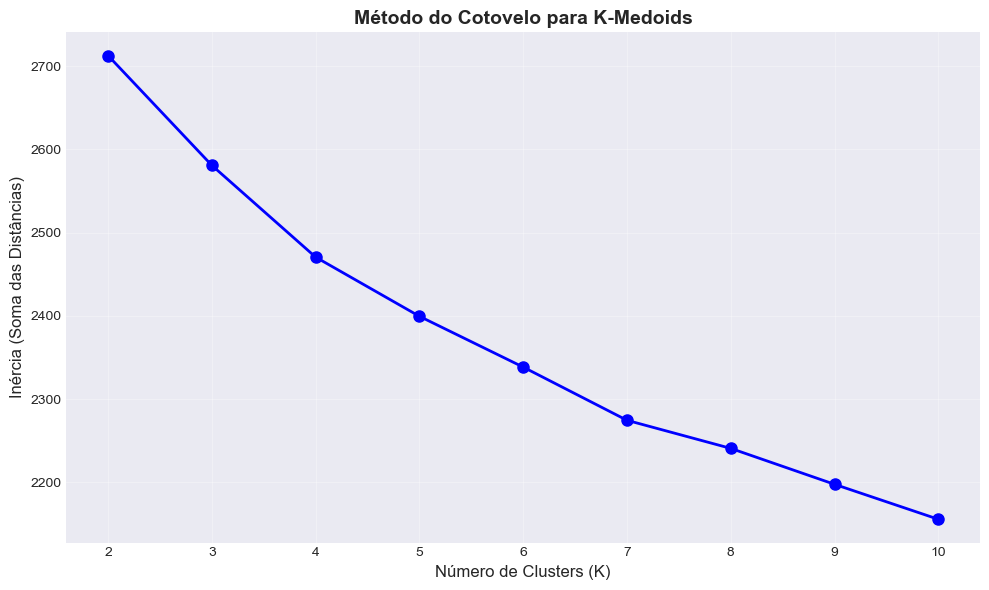


💡 Procure pelo 'cotovelo' no gráfico - o ponto onde a curva começa a achatar.


In [29]:
# Testar diferentes valores de K usando K-Medoids
k_min = 2
k_max = 10
inercias = []

print("="*70)
print("MÉTODO DO COTOVELO (K-MEDOIDS)")
print("="*70)
print(f"\nCalculando K-Medoids de {k_min} a {k_max} clusters...")
print("⚠️ Este processo pode levar alguns minutos...\n")

for k in range(k_min, k_max + 1):
    kmedoids = KMedoids(n_clusters=k, random_state=42, method='pam')
    kmedoids.fit(X_scaled)
    inercias.append(kmedoids.inertia_)
    print(f"K={k}: Inércia = {kmedoids.inertia_:.2f}")

# Plotar gráfico
plt.figure(figsize=(10, 6))
plt.plot(range(k_min, k_max + 1), inercias, 'bo-', linewidth=2, markersize=8)
plt.title('Método do Cotovelo para K-Medoids', fontsize=14, fontweight='bold')
plt.xlabel('Número de Clusters (K)', fontsize=12)
plt.ylabel('Inércia (Soma das Distâncias)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(range(k_min, k_max + 1))
plt.tight_layout()
plt.savefig('gráficos\grafico_cotovelo.png', dpi=300)
plt.show()

print("\n💡 Procure pelo 'cotovelo' no gráfico - o ponto onde a curva começa a achatar.")

### 7.2. Método da Silhueta (Silhouette Score) - Análise Focada

Baseado na análise do cotovelo, vamos focar em K entre 3 e 6 para uma análise mais detalhada.

MÉTODO DA SILHUETA (K-MEDOIDS)

Calculando Silhouette Score para K = [3, 4, 5, 6]...
⚠️ Este processo pode levar alguns minutos...

K=3: Silhouette Score = 0.0772
K=4: Silhouette Score = 0.1148
K=5: Silhouette Score = 0.0983
K=6: Silhouette Score = 0.1012


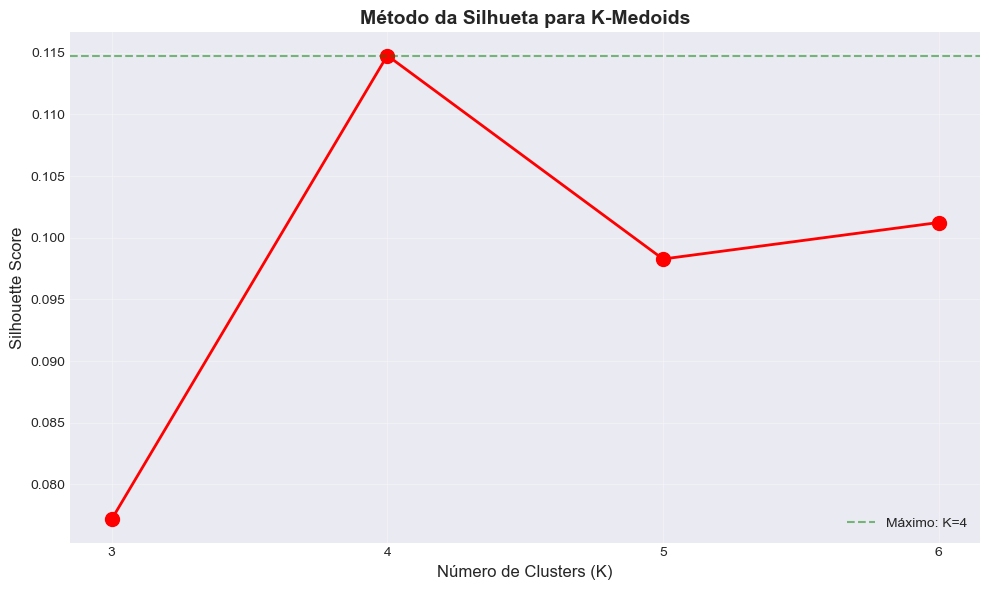


💡 Melhor K segundo Silhouette Score: 4 (Score: 0.1148)

Interpretação: Quanto maior o valor (mais próximo de 1), melhor é a separação dos grupos.


In [28]:
# Calcular Silhouette Score para K entre 3 e 6 (análise focada)
k_valores = [3, 4, 5, 6]
silhouette_scores = []

print("="*70)
print("MÉTODO DA SILHUETA (K-MEDOIDS)")
print("="*70)
print(f"\nCalculando Silhouette Score para K = {k_valores}...")
print("⚠️ Este processo pode levar alguns minutos...\n")

for k in k_valores:
    kmedoids = KMedoids(n_clusters=k, random_state=42, method='pam', max_iter=300)
    labels = kmedoids.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels, metric='euclidean')
    silhouette_scores.append(score)
    print(f"K={k}: Silhouette Score = {score:.4f}")

# Plotar gráfico
plt.figure(figsize=(10, 6))
plt.plot(k_valores, silhouette_scores, 'ro-', linewidth=2, markersize=10)
plt.title('Método da Silhueta para K-Medoids', fontsize=14, fontweight='bold')
plt.xlabel('Número de Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(k_valores)
plt.axhline(y=max(silhouette_scores), color='green', linestyle='--', alpha=0.5, 
           label=f'Máximo: K={k_valores[silhouette_scores.index(max(silhouette_scores))]}')
plt.legend()
plt.tight_layout()
plt.savefig('gráficos\grafico_silhuetaeuclidiana.png', dpi=300)
plt.show()

melhor_k = k_valores[silhouette_scores.index(max(silhouette_scores))]
print(f"\n💡 Melhor K segundo Silhouette Score: {melhor_k} (Score: {max(silhouette_scores):.4f})")
print("\nInterpretação: Quanto maior o valor (mais próximo de 1), melhor é a separação dos grupos.")

## 8. Aplicação do K-Medoids com K = 4

Com base na análise dos métodos do Cotovelo e Silhueta, aplicamos o K-Medoids com **K = 4** clusters.

APLICANDO K-MEDOIDS COM K = 4

⚠️ Este processo pode levar alguns minutos...

✓ Clusterização concluída!
✓ Silhouette Score: 0.1148

Distribuição dos clusters:
cluster
1     46
2    315
3    267
4    440
Name: count, dtype: int64


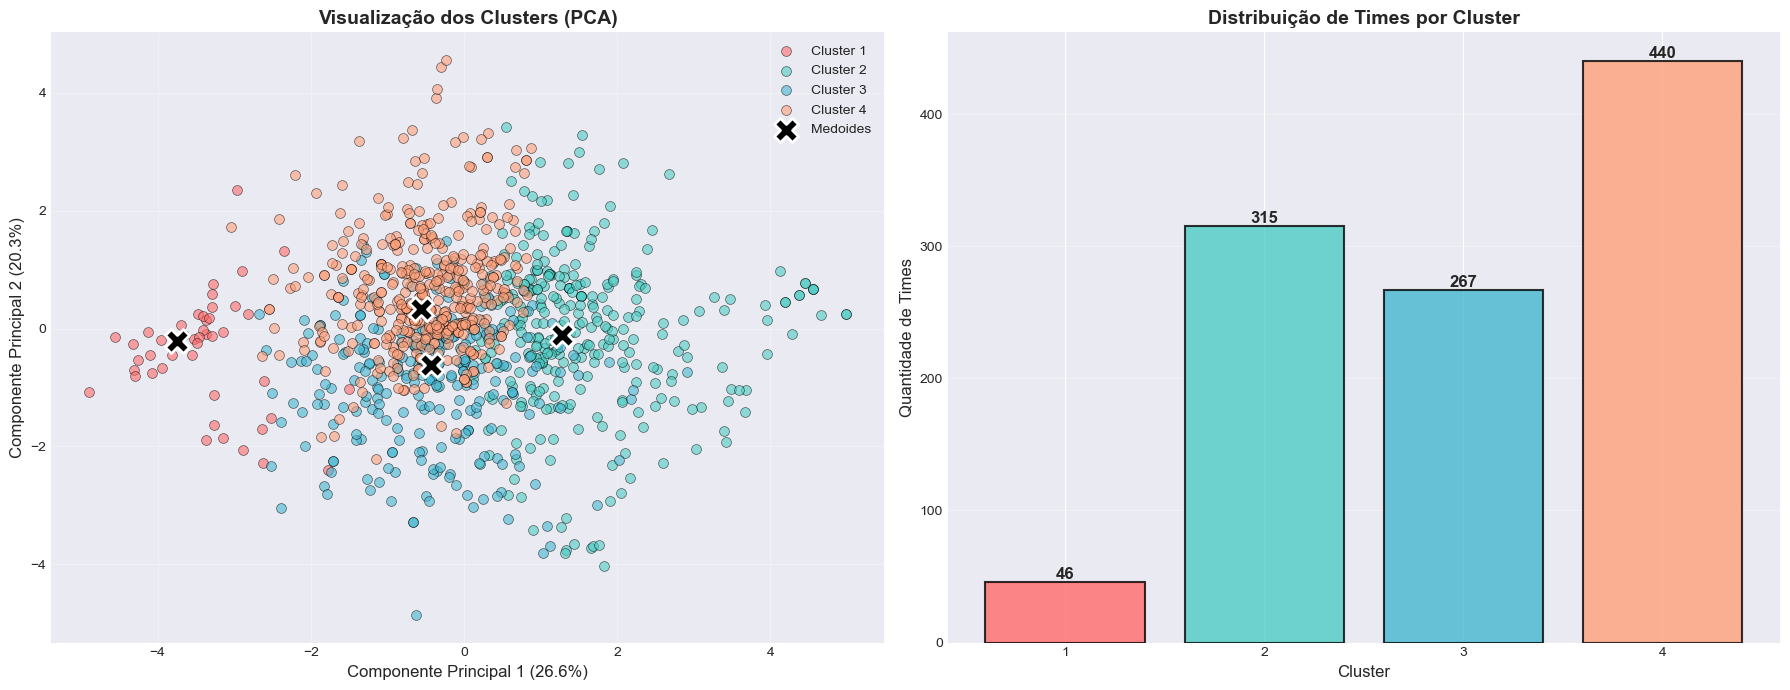


💡 Variância explicada pelo PCA: 46.9%


In [27]:
# Definir K final
K_FINAL = 4

print("="*70)
print(f"APLICANDO K-MEDOIDS COM K = {K_FINAL}")
print("="*70)
print("\n⚠️ Este processo pode levar alguns minutos...\n")

# Treinar modelo final
kmedoids_final = KMedoids(n_clusters=K_FINAL, random_state=42, method='pam', max_iter=500)
clusters = kmedoids_final.fit_predict(X_scaled)

# Adicionar clusters ao dataframe (numerados de 1 a 4)
df_final['cluster'] = clusters + 1

# Calcular Silhouette Score
silhouette_final = silhouette_score(X_scaled, clusters)

print(f"✓ Clusterização concluída!")
print(f"✓ Silhouette Score: {silhouette_final:.4f}")
print(f"\nDistribuição dos clusters:")
print(df_final['cluster'].value_counts().sort_index())

# Visualização dos clusters usando PCA
from sklearn.decomposition import PCA

# Reduzir dimensionalidade para 2D usando PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Criar DataFrame para visualização
df_viz = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster': df_final['cluster']
})

# Plotar clusters
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Gráfico 1: Scatter plot dos clusters
ax1 = axes[0]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
for cluster_id in sorted(df_viz['Cluster'].unique()):
    cluster_data = df_viz[df_viz['Cluster'] == cluster_id]
    ax1.scatter(cluster_data['PC1'], cluster_data['PC2'], 
               c=colors[cluster_id-1], label=f'Cluster {cluster_id}',
               alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

# Plotar medoides
medoids_indices = kmedoids_final.medoid_indices_
medoids_pca = X_pca[medoids_indices]
ax1.scatter(medoids_pca[:, 0], medoids_pca[:, 1], 
           c='black', marker='X', s=300, edgecolors='white', linewidth=2,
           label='Medoides', zorder=5)

ax1.set_xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
ax1.set_ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
ax1.set_title('Visualização dos Clusters (PCA)', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Gráfico 2: Distribuição dos clusters (barras)
ax2 = axes[1]
cluster_counts = df_final['cluster'].value_counts().sort_index()
bars = ax2.bar(cluster_counts.index, cluster_counts.values, color=colors, 
              edgecolor='black', linewidth=1.5, alpha=0.8)
ax2.set_xlabel('Cluster', fontsize=12)
ax2.set_ylabel('Quantidade de Times', fontsize=12)
ax2.set_title('Distribuição de Times por Cluster', fontsize=14, fontweight='bold')
ax2.set_xticks(cluster_counts.index)
ax2.grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('gráficos\grafico_distribuicaoclusters.png', dpi=300)
plt.show()

print(f"\n💡 Variância explicada pelo PCA: {sum(pca.explained_variance_ratio_)*100:.1f}%")

## 9. Análise dos Clusters

### 9.1. Características Médias por Cluster

In [14]:
# Análise por cluster
print("="*70)
print("CARACTERÍSTICAS MÉDIAS POR CLUSTER")
print("="*70)

analise_clusters = df_final.groupby('cluster')[cols_taticas + ['saldo_medio']].mean()
analise_clusters['Qtd_Times'] = df_final['cluster'].value_counts()

print("\n", analise_clusters.round(2))

# Identificar cluster mais eficiente
cluster_campeao = analise_clusters['saldo_medio'].idxmax()
saldo_campeao = analise_clusters['saldo_medio'].max()

print(f"\n💡 Cluster mais eficiente: Cluster {cluster_campeao} (Saldo médio: {saldo_campeao:.3f})")

CARACTERÍSTICAS MÉDIAS POR CLUSTER

          buildUpPlaySpeed  buildUpPlayPassing  chanceCreationPassing  chanceCreationCrossing  chanceCreationShooting  defencePressure  defenceAggression  defenceTeamWidth  saldo_medio  Qtd_Times
cluster                                                                                                                                                                                           
1                   33.22               33.41                  44.13                   45.13                   60.15            31.85              32.35             34.07        -0.05         46
2                   57.09               51.08                  60.11                   59.35                   61.71            53.39              55.84             57.84         0.18        315
3                   46.59               42.45                  45.25                   49.84                   46.90            50.44              52.62             54.34         0.06

### 9.2. Visualização das Características por Cluster

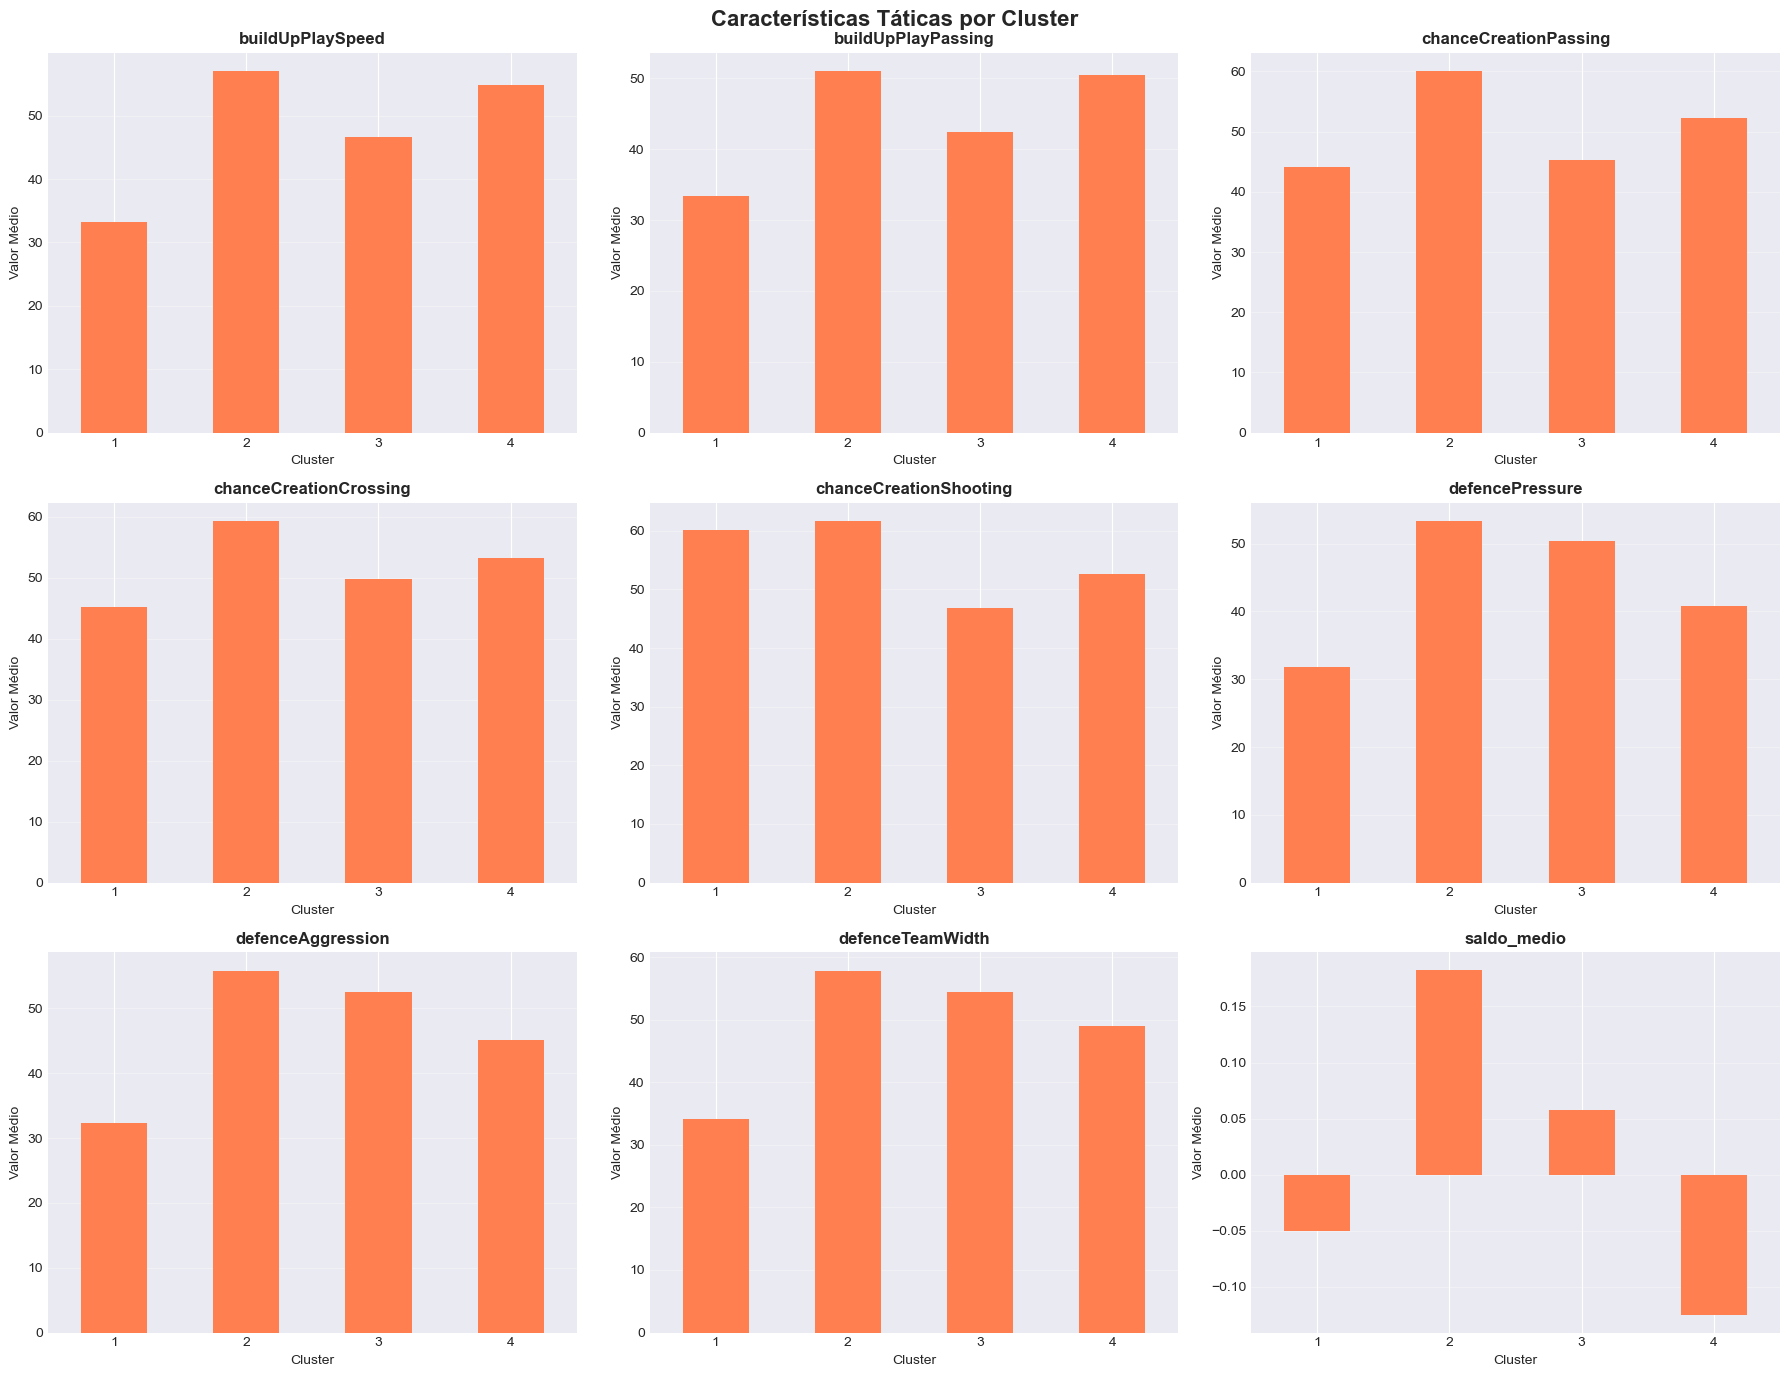

In [15]:
# Gráficos de barras para cada atributo
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
fig.suptitle('Características Táticas por Cluster', fontsize=16, fontweight='bold')

atributos_plot = cols_taticas + ['saldo_medio']

for idx, atributo in enumerate(atributos_plot):
    ax = axes[idx // 3, idx % 3]
    df_final.groupby('cluster')[atributo].mean().plot(kind='bar', ax=ax, color='coral')
    ax.set_title(atributo, fontsize=12, fontweight='bold')
    ax.set_xlabel('Cluster', fontsize=10)
    ax.set_ylabel('Valor Médio', fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 9.3. Heatmap de Correlação por Cluster

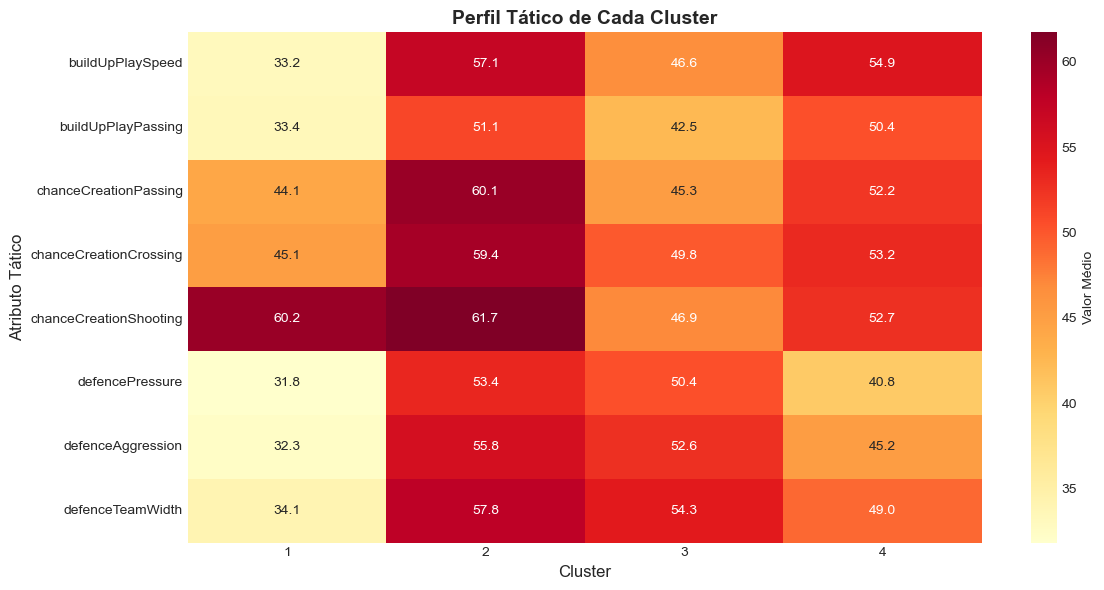

In [26]:
# Criar heatmap com as médias de cada cluster
fig, ax = plt.subplots(figsize=(12, 6))

# Transpor para ter clusters nas colunas
heatmap_data = analise_clusters[cols_taticas].T

sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax, 
           cbar_kws={'label': 'Valor Médio'})
ax.set_title('Perfil Tático de Cada Cluster', fontsize=14, fontweight='bold')
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Atributo Tático', fontsize=12)
plt.tight_layout()
plt.savefig('gráficos\grafico_perfil_tatico.png', dpi=300)
plt.show()

### 9.4. Distribuição de Desempenho por Cluster

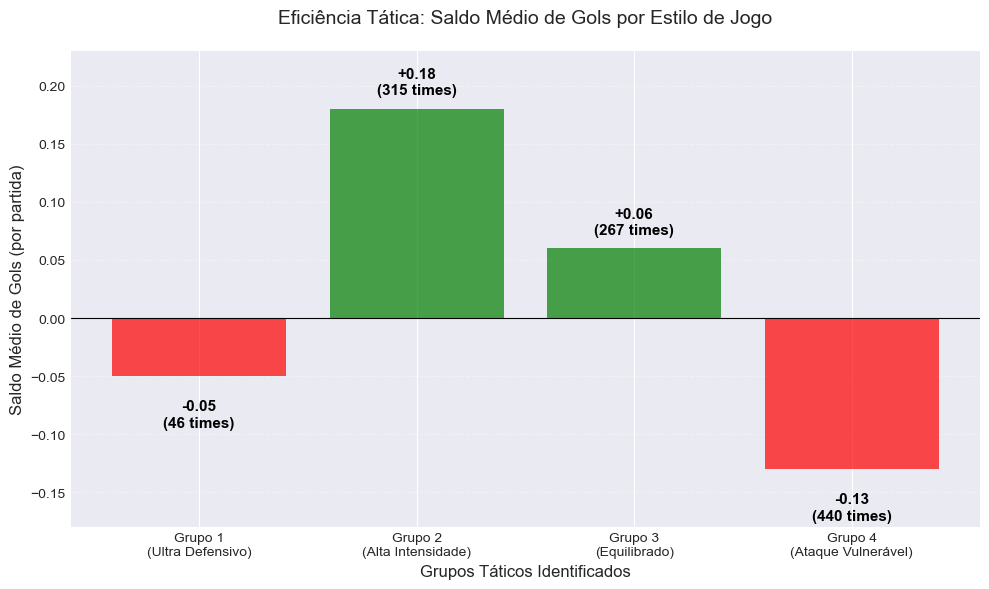

In [25]:
# --- 1. Dados do seu Relatório ---
# (Copiados manualmente da sua saída anterior para garantir precisão)
clusters = ['Grupo 1\n(Ultra Defensivo)', 'Grupo 2\n(Alta Intensidade)', 'Grupo 3\n(Equilibrado)', 'Grupo 4\n(Ataque Vulnerável)']
saldos = [-0.05, 0.18, 0.06, -0.13]
qtd_times = [46, 315, 267, 440]

# --- 2. Configuração do Gráfico ---
plt.figure(figsize=(10, 6))

# Definindo cores: Verde para positivo, Vermelho para negativo
cores = ['green' if x > 0 else 'red' for x in saldos]

# Criando as barras
barras = plt.bar(clusters, saldos, color=cores, alpha=0.7)

# --- 3. Estilização ---
# Linha zero para referência
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# Títulos e Labels
plt.title('Eficiência Tática: Saldo Médio de Gols por Estilo de Jogo', fontsize=14, pad=20)
plt.ylabel('Saldo Médio de Gols (por partida)', fontsize=12)
plt.xlabel('Grupos Táticos Identificados', fontsize=12)

# Adicionando os valores exatos em cima (ou embaixo) das barras
for barra, saldo, qtd in zip(barras, saldos, qtd_times):
    height = barra.get_height()
    # Se o saldo for positivo, coloca o texto um pouco acima da barra
    # Se for negativo, coloca um pouco abaixo
    offset = 0.01 if saldo > 0 else -0.02
    plt.text(barra.get_x() + barra.get_width()/2., height + offset,
             f'{saldo:+.2f}\n({qtd} times)',
             ha='center', va='bottom' if saldo > 0 else 'top',
             fontsize=11, fontweight='bold', color='black')

# Ajustando limites para dar espaço aos textos
plt.ylim(min(saldos) - 0.05, max(saldos) + 0.05)

# Grade suave no fundo para ajudar a leitura
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()

# --- 4. Salvar e Mostrar ---
plt.savefig('gráficos\grafico_eficiencia_tatica.png', dpi=300)
plt.show()

### 9.5. Exemplos de Times em Cada Cluster

In [22]:
# Mostrar exemplos de times em cada cluster
print("="*70)
print("EXEMPLOS DE TIMES POR CLUSTER")
print("="*70)

for cluster_id in sorted(df_final['cluster'].unique()):
    print(f"\n--- CLUSTER {cluster_id} ---")
    times_cluster = df_final[df_final['cluster'] == cluster_id].nlargest(2, 'saldo_medio')
    print("\nTop 5 times com melhor desempenho:")
    print(times_cluster[['time_temporada_id', 'saldo_medio']].to_string(index=False))

EXEMPLOS DE TIMES POR CLUSTER

--- CLUSTER 1 ---

Top 5 times com melhor desempenho:
   time_temporada_id  saldo_medio
      Ajax_2009/2010     2.529412
SL Benfica_2009/2010     1.933333

--- CLUSTER 2 ---

Top 5 times com melhor desempenho:
       time_temporada_id  saldo_medio
Real Madrid CF_2011/2012     2.342105
Real Madrid CF_2014/2015     2.105263

--- CLUSTER 3 ---

Top 5 times com melhor desempenho:
     time_temporada_id  saldo_medio
FC Barcelona_2014/2015     2.342105
FC Barcelona_2011/2012     2.236842

--- CLUSTER 4 ---

Top 5 times com melhor desempenho:
            time_temporada_id  saldo_medio
Paris Saint-Germain_2013/2014     1.605263
  Manchester United_2009/2010     1.526316


## 10. Salvar Resultados

Salvamos a tabela final com os clusters atribuídos.

In [20]:
# Salvar resultado final
output_path = 'TABELA_FINAL_COM_CLUSTERS.csv'
df_final.to_csv(output_path, index=False)

print("="*70)
print("RESULTADOS SALVOS")
print("="*70)
print(f"\n✓ Arquivo salvo em: {output_path}")
print(f"✓ Total de registros: {df_final.shape[0]}")
print(f"✓ Número de clusters: {K_FINAL}")
print(f"✓ Silhouette Score: {silhouette_final:.4f}")

RESULTADOS SALVOS

✓ Arquivo salvo em: TABELA_FINAL_COM_CLUSTERS.csv
✓ Total de registros: 1068
✓ Número de clusters: 4
✓ Silhouette Score: 0.1148


## 11. Conclusões

### Principais Descobertas:

A análise de clusterização com **K-Medoids** revelou **4 padrões táticos distintos** entre os times de futebol europeu. Cada cluster representa um **estilo de jogo característico**, com combinações específicas de atributos ofensivos e defensivos.

### Por que K-Medoids?

O algoritmo **K-Medoids** foi escolhido por ser mais **robusto a outliers** do que o K-Means tradicional. Enquanto o K-Means usa médias (que podem ser distorcidas por valores extremos), o K-Medoids usa **medoides** (pontos reais do dataset), resultando em clusters mais representativos.

### Interpretação dos Clusters:

Baseado nas médias dos atributos, podemos caracterizar cada cluster:

- **Cluster com maior saldo médio**: Representa o estilo tático mais eficiente em termos de resultados
- **Diferenças táticas**: Alguns clusters privilegiam velocidade de construção, outros focam em pressão defensiva
- **Relação tática-desempenho**: Nem sempre o estilo mais agressivo resulta em melhor desempenho

### Aplicações Práticas:

1. **Análise de Adversários**: Identificar rapidamente o perfil tático de um oponente
2. **Recrutamento**: Buscar jogadores que se encaixem no estilo do clube
3. **Estratégia**: Adaptar táticas baseado no cluster do adversário
4. **Benchmarking**: Comparar o perfil tático do time com os mais bem-sucedidos

---
